## 章節 7：預測（Prediction）

### 7.4 得分的分佈

P(H) ：目前為止平均得分的機率（一開始用高斯分佈代表）
P(D) ：下場比賽得分的機率

P(D|H) 目前得分的平均已知的情況下，下一場比賽得 x 分的機率 （poisson 分佈）

D 是給定的

為了計算各隊贏得下一場比賽的機率，我們需要計算各隊得分的分佈。

如果我們精確知道 lam，我們可以再一次用帕松分佈。thinkbayes.py 提供一個計算截斷後的近似帕松分佈：

provides a method that computes a truncated approximation of a Poisson distribution:

<pre>
def MakePoissonPmf(lam, high):
    pmf = Pmf()
    for k in xrange(0, high+1): # 限制最高得分的範圍為 high
        p = EvalPoissonPmf(k, lam)
        pmf.Set(k, p)
        
    pmf.Normalize()
    return pmf
</pre>

Pmf 的得分範圍從 0 到 high。所以如果 lam 為 3.4 我們可以計算：

<pre>
lam = 3.4
goal_dist = thinkbayes.MakePoissonPmf(lam, 10)
</pre>

上面的 high 我選擇 10 ，因為在比賽中得分超過 10 分的情形非常少。

目前為止很簡單；但問題是我們不精確知道 lam （他是一個隨機變數）。相反的，我們有 lam 所有可能數值的分佈。對於每個數值 lam ，單場得分的分佈是帕松分佈。所以整體的單場得分分佈是這些帕松分佈的混合體（Mixture），每個帕松分佈依據 lam 發生的機率做加權。

給定 lam 的後驗分佈，下方程式碼產生單場得分的分佈：

<pre>
def MakeGoalPmf(suite):
    metapmf = thinkbayes.Pmf()
    for lam, prob in suite.Items():
        pmf = thinkbayes.MakePoissonPmf(lam, 10)
        metapmf.Set(pmf, prob)
    mix = thinkbayes.MakeMixture(metapmf)
    return mix
</pre>

針對每個數值 lam 我們計算 Poisson 的 Pmf 並且加入到 meta-Pmf。我用 meta-Pmf 是因為它是一個用 Pmf 為數值的 Pmf。藉著我們用 MakeMixture 方法計算混合體（我們在 5.6 小節看過 MakeMixture）。

請參考最下方程式碼。

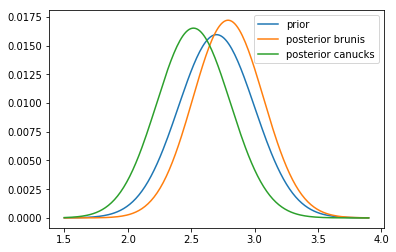

Bruins 隊的最可能的平均得分： 2.7960000000000003
Canucks 隊的最可能的平均得分： 2.5200000000000005


In [16]:
import thinkbayes as tb
import matplotlib.pyplot as plt

class Hockey(tb.Suite):

    def __init__(self, name):
        # 先驗分佈為高斯分佈
        # 平均值 2.7
        # 標準差 0.3
        # 平均值上下各 4 個標準差
        pmf = tb.MakeGaussianPmf(2.7, 0.3, 4)
        tb.Suite.__init__(self, pmf)
        
        self.name = name
        
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = tb.EvalPoissonPmf(k, lam)
        return like

def plot_dist(dist):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y)


def make_likelihood_dist(data, suite):
    pmf = tb.Pmf()
    for lam, _ in suite.Items():
        pmf.Set(lam, suite.Likelihood(data, lam))
    
    pmf.Normalize()
    return pmf


suite1 = Hockey('bruins')
plot_dist(suite1)
suite1.UpdateSet([0, 2, 8, 4])
suite2 = Hockey('canucks')
suite2.UpdateSet([1, 3, 1, 0])

plot_dist(suite1)
plot_dist(suite2)
plt.legend(["prior", "posterior brunis", "posterior canucks"])
plt.show()

print("Bruins 隊的最可能的平均得分：", suite1.MaximumLikelihood())
print("Canucks 隊的最可能的平均得分：", suite2.MaximumLikelihood()) 

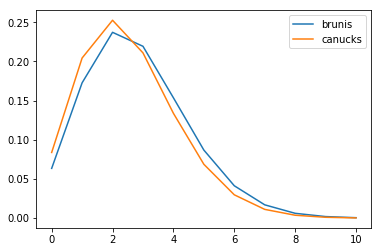

下場比賽 bruins 對得分的期望值： 2.7935105359143235
下場比賽 canucks 對得分的期望值： 2.520302000470636


In [19]:
def MakeMixture(pmf):
    mix = tb.Pmf()
    for sub_pmf, weight in pmf.Items():
        for v, prob in sub_pmf.Items():
            mix.Incr(v, weight*prob)
    
    mix.Normalize()
    return mix

def MakePoissonPmf(lam, high):
    pmf = tb.Pmf()
    for i in range(high+1):
        pmf.Set(i, tb.EvalPoissonPmf(i, lam))
    
    pmf.Normalize()
    return pmf

def MakeGoalPmf(suite, high=10):
    # suite: 後驗分佈
    meta_pmf = tb.Pmf()
    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, high)
        meta_pmf.Set(pmf, prob)
    
    mix = MakeMixture(meta_pmf)
    return mix

bruins_goal_pmf = MakeGoalPmf(suite1)
canucks_goal_pmf = MakeGoalPmf(suite2)

plot_dist(bruins_goal_pmf)
plot_dist(canucks_goal_pmf)
plt.legend(["brunis", "canucks"])
plt.show()

print("下場比賽 bruins 對得分的期望值：", bruins_goal_pmf.Mean())
print("下場比賽 canucks 對得分的期望值：", canucks_goal_pmf.Mean())

上圖為棕熊隊跟加人隊下場比賽的得分分佈。棕熊隊不太可能進 3 球或更少，甚至有可能到得到 4 分。